In [7]:
# reload packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Choose GPU (this may not be needed on your computer)

In [8]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [9]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### load packages

In [10]:
from tfumap.umap import tfUMAP

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [12]:
dataset = 'cassins_dtw'
dims = (32,32,1)

In [13]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

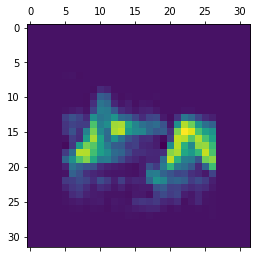

In [14]:
syllable_df = pd.read_pickle(DATA_DIR/'cassins'/ 'cassins.pickle')

#syllable_df= syllable_df[:1000]

syllable_df[:3]

top_labels = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels.values == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:20]
    .T
)
top_labels

syllable_df = syllable_df[syllable_df.labels.isin(top_labels.columns)]

syllable_df[:3]

syllable_df = syllable_df.reset_index()

syllable_df['subset'] = 'train'
syllable_df.loc[:1000, 'subset'] = 'valid'
syllable_df.loc[1000:1999, 'subset'] = 'test'
#syllable_df.loc[:100, 'subset'] = 'valid'
#syllable_df.loc[100:199, 'subset'] = 'test'

specs = np.array(list(syllable_df.spectrogram.values))
specs = np.array([np.concatenate([np.zeros((32,1)), i], axis=1) for i in tqdm(specs)])
specs.shape

syllable_df['spectrogram'] = syllable_df['spectrogram'].astype('object')
syllable_df['spectrogram'] = list(specs)

np.shape(syllable_df['spectrogram'].values[0])

len(syllable_df)

Y_train = np.array(list(syllable_df.labels.values[syllable_df.subset == 'train']))
Y_valid = np.array(list(syllable_df.labels.values[syllable_df.subset == 'valid']))
Y_test = np.array(list(syllable_df.labels.values[syllable_df.subset == 'test']))

X_train = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'train'])) #/ 255.
X_valid = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'valid']))# / 255.
X_test = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'test'])) #/ 255.

X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
Y_train = enc.fit_transform([[i] for i in Y_train]).astype('int').flatten()
Y_test = enc.fit_transform([[i] for i in Y_test]).astype('int').flatten()
plt.matshow(X_train[10])

In [15]:
len(X_train), len(X_test), len(X_valid)

(24984, 1000, 1000)

### Create model and train

In [9]:
from tensorflow.keras.layers import (
    Conv2D,
    Reshape,
    Bidirectional,
    Dense,
    RepeatVector,
    TimeDistributed,
    LSTM
)
n_components=64

#shape_final = (8,2,128)

encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu, padding="same"
    ),
    Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu, padding="same"
    ),
    Conv2D(
        filters=128, kernel_size=3, strides=(2, 1), activation=tf.nn.leaky_relu, padding="same"
    ),
    Conv2D(
        filters=128, kernel_size=3, strides=(2, 1), activation=tf.nn.leaky_relu, padding="same"
    ),
    Reshape(target_shape=(8, 2*128)),
    Bidirectional(LSTM(units=100, activation="relu")),
    Dense(units=512),
    Dense(units=n_components),
])

In [10]:
batch_size = 5000

In [11]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [12]:
from tfumap.parametric_tsne import compute_joint_probabilities, tsne_loss

In [13]:
save_loc = DATA_DIR/ 'parametric_tsne'/ dataset / 'P.npy'
if save_loc.exists():
    P = np.load(save_loc)
else:
    P = compute_joint_probabilities(X_train_flat, batch_size=batch_size, perplexity=30, verbose=2)
    ensure_dir(save_loc)
    np.save(save_loc, P)

In [14]:
X_train_subset = X_train[:np.product(P.shape[:2])]

In [15]:
# Joint probabilities of data
Y_train_tsne = P.reshape(X_train_subset.shape[0], -1)

In [16]:
X_train.shape[0]

24984

In [17]:
opt = tf.keras.optimizers.Adam(lr=0.01)

In [18]:
n_components = 64
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.InputLayer(input_shape=dims))
encoder.add(tf.keras.layers.Flatten())
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(
    tf.keras.layers.Dense(units=n_components, name="z")
)

In [19]:
encoder.compile(loss=tsne_loss(d=n_components, batch_size=batch_size), optimizer=opt)

In [20]:
X_train_subset = np.reshape(X_train_subset, ([len(X_train_subset)]+ list(dims)))
X_test = np.reshape(X_test, ([len(X_test)]+ list(dims)))

In [21]:
# because shuffle == False, the same batches are used each time...
history = encoder.fit(X_train_subset, Y_train_tsne, batch_size=batch_size, shuffle=False, nb_epoch=1000)

W0720 11:37:26.734768 140317826811712 training.py:792] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 20000 samples
Epoch 1/1000
20000/20000 [==============================] - 12s 606us/sample - loss: 2.9519
Epoch 2/1000
20000/20000 [==============================] - 0s 24us/sample - loss: 1.2911
Epoch 3/1000
20000/20000 [==============================] - 0s 21us/sample - loss: 1.0436
Epoch 4/1000
20000/20000 [==============================] - 0s 21us/sample - loss: 0.9152
Epoch 5/1000
20000/20000 [==============================] - 1s 28us/sample - loss: 0.8229
Epoch 6/1000
20000/20000 [==============================] - 0s 23us/sample - loss: 0.7581
Epoch 7/1000
20000/20000 [==============================] - 0s 21us/sample - loss: 0.6992
Epoch 8/1000
20000/20000 [==============================] - 0s 21us/sample - loss: 0.6551
Epoch 9/1000
20000/20000 [==============================] - 0s 25us/sample - loss: 0.6189
Epoch 10/1000
20000/20000 [==============================] - 0s 24us/sample - loss: 0.5855
Epoch 11/1000
20000/20000 [==============================] - 0s 23us/sampl

20000/20000 [==============================] - 1s 29us/sample - loss: 0.2120
Epoch 180/1000
20000/20000 [==============================] - 0s 24us/sample - loss: 0.2112
Epoch 181/1000
20000/20000 [==============================] - 0s 24us/sample - loss: 0.2068
Epoch 182/1000
20000/20000 [==============================] - 1s 25us/sample - loss: 0.2071
Epoch 183/1000
20000/20000 [==============================] - 0s 22us/sample - loss: 0.2101
Epoch 184/1000
20000/20000 [==============================] - 0s 24us/sample - loss: 0.2092
Epoch 185/1000
20000/20000 [==============================] - 0s 23us/sample - loss: 0.2081
Epoch 186/1000
20000/20000 [==============================] - 0s 23us/sample - loss: 0.2074
Epoch 187/1000
20000/20000 [==============================] - 0s 21us/sample - loss: 0.2053
Epoch 188/1000
20000/20000 [==============================] - 0s 23us/sample - loss: 0.2041
Epoch 189/1000
20000/20000 [==============================] - 0s 20us/sample - loss: 0.2040
Epo

20000/20000 [==============================] - 0s 24us/sample - loss: 0.1841
Epoch 358/1000
20000/20000 [==============================] - 0s 25us/sample - loss: 0.1827
Epoch 359/1000
20000/20000 [==============================] - 1s 28us/sample - loss: 0.1792
Epoch 360/1000
20000/20000 [==============================] - 0s 25us/sample - loss: 0.1791
Epoch 361/1000
20000/20000 [==============================] - 1s 45us/sample - loss: 0.1775
Epoch 362/1000
20000/20000 [==============================] - 1s 38us/sample - loss: 0.1752
Epoch 363/1000
20000/20000 [==============================] - 1s 28us/sample - loss: 0.1774
Epoch 364/1000
20000/20000 [==============================] - 0s 19us/sample - loss: 0.1786
Epoch 365/1000
20000/20000 [==============================] - 0s 25us/sample - loss: 0.1817
Epoch 366/1000
20000/20000 [==============================] - 0s 24us/sample - loss: 0.1839
Epoch 367/1000
20000/20000 [==============================] - 1s 33us/sample - loss: 0.1821
Epo

20000/20000 [==============================] - 1s 25us/sample - loss: 0.1760
Epoch 447/1000
20000/20000 [==============================] - 1s 25us/sample - loss: 0.1773
Epoch 448/1000
20000/20000 [==============================] - 0s 22us/sample - loss: 0.1782
Epoch 449/1000
20000/20000 [==============================] - 0s 21us/sample - loss: 0.1793
Epoch 450/1000
20000/20000 [==============================] - 0s 20us/sample - loss: 0.1765
Epoch 451/1000
20000/20000 [==============================] - 0s 24us/sample - loss: 0.1722
Epoch 452/1000
20000/20000 [==============================] - 0s 22us/sample - loss: 0.1739
Epoch 453/1000
20000/20000 [==============================] - 1s 28us/sample - loss: 0.1694
Epoch 454/1000
20000/20000 [==============================] - 0s 22us/sample - loss: 0.1680
Epoch 455/1000
20000/20000 [==============================] - 1s 27us/sample - loss: 0.1690
Epoch 456/1000
20000/20000 [==============================] - 0s 23us/sample - loss: 0.1701
Epo

20000/20000 [==============================] - 1s 32us/sample - loss: 0.1685
Epoch 625/1000
20000/20000 [==============================] - 1s 26us/sample - loss: 0.1668
Epoch 626/1000
20000/20000 [==============================] - 0s 23us/sample - loss: 0.1652
Epoch 627/1000
20000/20000 [==============================] - 0s 24us/sample - loss: 0.1647
Epoch 628/1000
20000/20000 [==============================] - 0s 23us/sample - loss: 0.1637
Epoch 629/1000
20000/20000 [==============================] - 0s 23us/sample - loss: 0.1613
Epoch 630/1000
20000/20000 [==============================] - 1s 37us/sample - loss: 0.1602
Epoch 631/1000
20000/20000 [==============================] - 1s 25us/sample - loss: 0.1591
Epoch 632/1000
20000/20000 [==============================] - 1s 26us/sample - loss: 0.1593
Epoch 633/1000
20000/20000 [==============================] - 1s 25us/sample - loss: 0.1570
Epoch 634/1000
20000/20000 [==============================] - 1s 26us/sample - loss: 0.1562
Epo

20000/20000 [==============================] - 0s 24us/sample - loss: 0.1609
Epoch 803/1000
20000/20000 [==============================] - 0s 23us/sample - loss: 0.1597
Epoch 804/1000
20000/20000 [==============================] - 0s 23us/sample - loss: 0.1583
Epoch 805/1000
20000/20000 [==============================] - 0s 25us/sample - loss: 0.1561
Epoch 806/1000
20000/20000 [==============================] - 0s 25us/sample - loss: 0.1560
Epoch 807/1000
20000/20000 [==============================] - 0s 19us/sample - loss: 0.1546
Epoch 808/1000
20000/20000 [==============================] - 1s 25us/sample - loss: 0.1551
Epoch 809/1000
20000/20000 [==============================] - 0s 23us/sample - loss: 0.1564
Epoch 810/1000
20000/20000 [==============================] - 0s 21us/sample - loss: 0.1557
Epoch 811/1000
20000/20000 [==============================] - 1s 26us/sample - loss: 0.1544
Epoch 812/1000
20000/20000 [==============================] - 1s 28us/sample - loss: 0.1534
Epo

20000/20000 [==============================] - 0s 20us/sample - loss: 0.1545
Epoch 981/1000
20000/20000 [==============================] - 0s 21us/sample - loss: 0.1552
Epoch 982/1000
20000/20000 [==============================] - 1s 33us/sample - loss: 0.1575
Epoch 983/1000
20000/20000 [==============================] - 1s 42us/sample - loss: 0.1563
Epoch 984/1000
20000/20000 [==============================] - 0s 19us/sample - loss: 0.1549
Epoch 985/1000
20000/20000 [==============================] - 0s 20us/sample - loss: 0.1526
Epoch 986/1000
20000/20000 [==============================] - 0s 21us/sample - loss: 0.1508
Epoch 987/1000
20000/20000 [==============================] - 0s 19us/sample - loss: 0.1514
Epoch 988/1000
20000/20000 [==============================] - 0s 19us/sample - loss: 0.1499
Epoch 989/1000
20000/20000 [==============================] - 0s 22us/sample - loss: 0.1497
Epoch 990/1000
20000/20000 [==============================] - 0s 18us/sample - loss: 0.1504
Epo

### get z for training and test

In [22]:
X_train = np.reshape(X_train, ([len(X_train)]+ list(dims)))

In [23]:
z = encoder.predict(X_train)
z_test = encoder.predict(X_test)

### Test plot

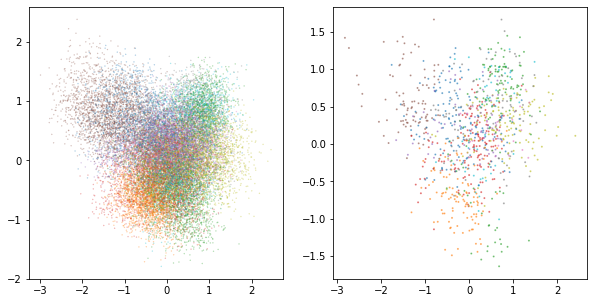

In [24]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=Y_train[:len(z)], cmap=plt.cm.tab10)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=Y_test, cmap=plt.cm.tab10)

### Save models + projections

In [25]:
import os

In [26]:
output_dir = MODEL_DIR/'projections'/ dataset / '64' /'parametric-tsne'

In [27]:
encoder.save(os.path.join(output_dir, "encoder"))

W0720 11:46:12.043585 140317826811712 deprecation.py:506] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
I0720 11:46:12.254611 140317826811712 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins_dtw/64/parametric-tsne/encoder/assets


In [28]:
np.save(output_dir / 'z.npy', z)
np.save(output_dir / 'z_test.npy', z_test)

### compute metrics

#### silhouette

In [29]:
from tfumap.silhouette import silhouette_score_block

In [30]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

0.2298678395091246

In [31]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

0.2880793528011794

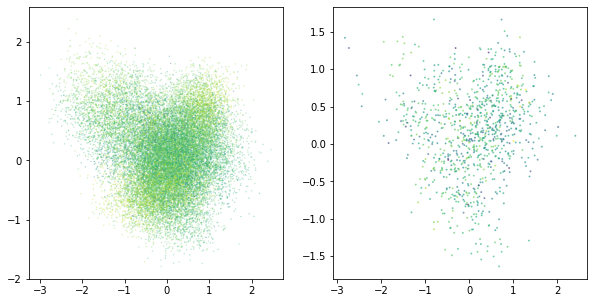

In [32]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train)
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

0.995

In [35]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

0.995

#### Trustworthiness

In [36]:
from sklearn.manifold import trustworthiness

In [37]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [38]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [39]:
tw, tw_test

(0.9989834847878303, 0.9976320564516129)

#### save output metrics

In [40]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, 'parametric-tsne', n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,cassins_dtw,parametric-tsne,64,0.998983,0.229868,"[0.31508379297035033, 0.15809932878986563, 0.2..."


In [41]:
save_loc = DATA_DIR / 'projection_metrics' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

In [42]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, 'parametric-tsne', n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,cassins_dtw,parametric-tsne,64,0.997632,0.288079,"[0.26445685283593057, 0.3958979669562433, 0.26..."


In [43]:
save_loc = DATA_DIR / 'projection_metrics' / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

In [44]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = ['parametric-tsne', n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,parametric-tsne,64,cassins_dtw,0.995,0.995


In [45]:
save_loc = DATA_DIR / 'knn_classifier' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)